# Meridional heat transport with masks

In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import cmocean as cm
from collections import OrderedDict
import cftime
import glob

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

In [2]:
db = '/scratch/e14/cy8964/access-om2/archive/databases/1deg_jra55_ryf_experiments_2.db'
session = cc.database.create_session(db)

In [3]:
exptdict = OrderedDict([
    ('Control',  {'expt':'1deg_jra55_ryf_RCPcont'}),
    ('Warming',  {'expt':'1deg_jra55_ryf_RCPwarmhumid'}),
    ('Warming x2',  {'expt':'1deg_jra55_ryf_RCPwarmhumid2x'}),
    ('Cooling',  {'expt':'1deg_jra55_ryf_RCPcoolhumid'}),
    ('Cooling x2',  {'expt':'1deg_jra55_ryf_RCPcoolhumid2x'}),
    ('Warming w/o humidity',  {'expt':'1deg_jra55_ryf_rcpwarm'}),
    ('Cooling w/o humidity',  {'expt':'1deg_jra55_ryf_rcpcool'}),
    ('Cooling w/o humidity2', {'expt':'1deg_jra55_ryf_RCPcool'}),
    ('Windup', {'expt':'1deg_jra55_ryf_red3DSK_C9'})

])


In [4]:
start_time = '2900-01-01'


## missing temp_yflux_submeso_int_z

In [5]:
def find_MHF_intz(ekey):
    expt = exptdict[ekey]['expt']
    #n_files = exptdict[ekey]['n_files']
    # n_files = 1
    #time_units = exptdict[ekey]['time_units']
    #offset = exptdict[ekey]['offset']

    temp_yflux_adv = cc.querying.getvar(expt, 'temp_yflux_adv_int_z', session)
    #temp_yflux_submeso = cc.querying.getvar(expt, 'temp_yflux_submeso_int_z', session)
    MHF = (temp_yflux_adv.sel(time=slice(tstart,tend)).mean('time').sum('xt_ocean')).load()#+temp_yflux_submeso.sel(time=slice(tstart,tend)).mean('time').sum('xt_ocean')).load()
    if (ekey != '01deg'):
        temp_yflux_gm = cc.querying.getvar(expt,'temp_yflux_gm_int_z', session)
        temp_yflux_ndiffuse = cc.querying.getvar(expt, 'temp_yflux_ndiffuse_int_z',session)
        MHF = MHF + (temp_yflux_gm.sel(time=slice(tstart,tend)).mean('time').sum('xt_ocean')+temp_yflux_ndiffuse.sel(time=slice(tstart,tend)).mean('time').sum('xt_ocean')).load()

    latv = cc.querying.getvar(expt, 'yu_ocean',session, n=1).load()
    return latv, MHF

Control
Warming
Warming x2
Cooling
Cooling x2
Warming w/o humidity


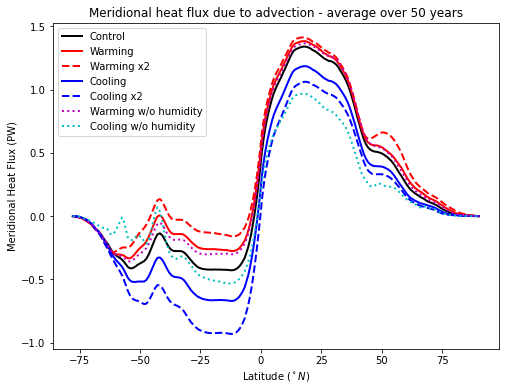

In [6]:
fig = plt.figure(figsize=(8,6))
plt.xlabel('Latitude $(^\circ N)$')
plt.ylabel('Meridional Heat Flux (PW)')
tstart = '2900-01-01'
tend = '2949-01-01'
keys = ['Control','Warming','Warming x2','Cooling','Cooling x2', 'Warming w/o humidity']

colors = {'Control': 'k','Warming': 'r','Warming x2': 'r','Cooling':'b','Cooling x2':'b', 'Warming w/o humidity':'m','Cooling w/o humidity2':'c'}
linestyles = {'Control': '-','Warming': '-','Warming x2': '--','Cooling':'-','Cooling x2':'--', 'Warming w/o humidity':'dotted','Cooling w/o humidity2':'dotted'}

for ekey in keys:
    print(ekey)

    latv, MHF = find_MHF_intz(ekey)
    hand = plt.plot(latv,MHF/1.e15,linewidth=2, label=ekey, color = colors[ekey], linestyle = linestyles[ekey])

#now the two cooling experiments bc they are split up
expt1 = '1deg_jra55_ryf_rcpcool'
temp_yflux_adv1 = cc.querying.getvar(expt1, 'temp_yflux_adv_int_z', session).sel(time = slice('2900-01-01','2909-01-01'))
expt2 = '1deg_jra55_ryf_RCPcool'
temp_yflux_adv2 = cc.querying.getvar(expt2, 'temp_yflux_adv_int_z', session).sel(time = slice('2909-01-01','2949-01-01'))
temp_yflux_adv_combined = xr.concat([temp_yflux_adv1,temp_yflux_adv2], dim = 'time')
MHF = (temp_yflux_adv_combined.mean('time').sum('xt_ocean')).load()#+temp_yflux_submeso.sel(time=slice(tstart,tend)).mean('time').sum('xt_ocean')).load()
latv = cc.querying.getvar(expt2, 'yu_ocean',session, n=1).load()
hand = plt.plot(latv,MHF/1.e15,linewidth=2, label='Cooling w/o humidity', color = 'c', linestyle = 'dotted')

plt.legend()
plt.title('Meridional heat flux due to advection - average over 50 years')
plt.savefig('figures/meridional_heat_flux')

In [48]:
temp_yflux_adv_combined

,Array,Chunk
Bytes,254.02 MB,432.00 kB
Shape,"(588, 300, 360)","(1, 300, 360)"
Count,3104 Tasks,588 Chunks
Type,float32,numpy.ndarray


Control
Warming
Warming x2
Cooling
Cooling x2
Warming w/o humidity
Cooling w/o humidity


Text(0.5, 1.0, 'Meridional heat flux due to advection years 1-10')

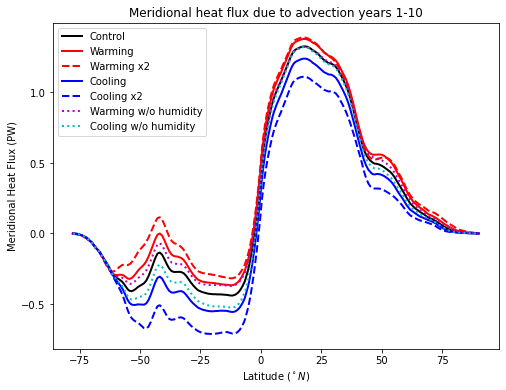

In [41]:
fig = plt.figure(figsize=(8,6))
plt.xlabel('Latitude $(^\circ N)$')
plt.ylabel('Meridional Heat Flux (PW)')
tstart = '2900-01-01'
tend = '2910-01-01'
keys = ['Control','Warming','Warming x2','Cooling','Cooling x2', 'Warming w/o humidity', 'Cooling w/o humidity']

colors = {'Control': 'k','Warming': 'r','Warming x2': 'r','Cooling':'b','Cooling x2':'b', 'Warming w/o humidity':'m','Cooling w/o humidity':'c'}
linestyles = {'Control': '-','Warming': '-','Warming x2': '--','Cooling':'-','Cooling x2':'--', 'Warming w/o humidity':'dotted','Cooling w/o humidity':'dotted'}

for ekey in keys:
    print(ekey)

    latv, MHF = find_MHF_intz(ekey)
    hand = plt.plot(latv,MHF/1.e15,linewidth=2, label=ekey, color = colors[ekey], linestyle = linestyles[ekey])
    
plt.legend()
plt.title('Meridional heat flux due to advection years 1-10')

Control
Warming
Warming x2
Cooling
Cooling x2
Warming w/o humidity
Cooling w/o humidity2


Text(0.5, 1.0, 'Meridional heat flux due to advection years 40-50')

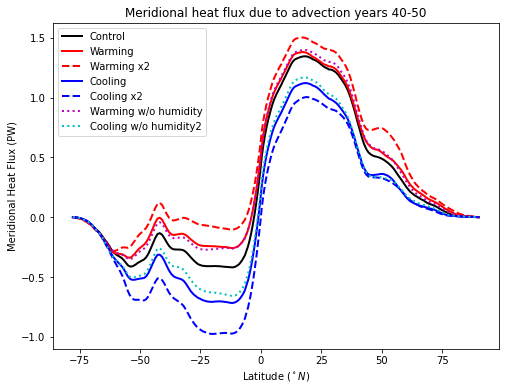

In [42]:
fig = plt.figure(figsize=(8,6))
plt.xlabel('Latitude $(^\circ N)$')
plt.ylabel('Meridional Heat Flux (PW)')
tstart = '2940-01-01'
tend = '2950-01-01'
keys = ['Control','Warming','Warming x2','Cooling','Cooling x2', 'Warming w/o humidity', 'Cooling w/o humidity2']

colors = {'Control': 'k','Warming': 'r','Warming x2': 'r','Cooling':'b','Cooling x2':'b', 'Warming w/o humidity':'m','Cooling w/o humidity2':'c'}
linestyles = {'Control': '-','Warming': '-','Warming x2': '--','Cooling':'-','Cooling x2':'--', 'Warming w/o humidity':'dotted','Cooling w/o humidity2':'dotted'}

for ekey in keys:
    print(ekey)

    latv, MHF = find_MHF_intz(ekey)
    hand = plt.plot(latv,MHF/1.e15,linewidth=2, label=ekey, color = colors[ekey], linestyle = linestyles[ekey])
    
plt.legend()
plt.title('Meridional heat flux due to advection years 40-50')

this means that in the warming case, the meridional heat flux increases so there is more heat pumping northwards and less southwards from the equator.

so the prediction that pumping slows, causing a cooling in northern hemisphere, might not be right (to explain the increase in surface flux at 40N in the 2x warming)

similarly, when the atmosphere is cooled, there is more heat pumping southwards and less northwards.

if the humidity is not changed then there is less of an anomaly from the control. this is because (in warming case) heat can be lost from equator, so less heat to advect northwards compared to if heat can't just evaporate at equator.

making masks for atlantic and indo-pacific

In [7]:
expt = '1deg_jra55_ryf_RCPcont'
ht = cc.querying.getvar(expt,'ht',session,n=-1)
land_mask = ~ht.isnull()

south_map = (land_mask.where(land_mask.yt_ocean < -34)).fillna(0) 
indo_map1 = (land_mask.where(land_mask.yt_ocean < 9).where(land_mask.yt_ocean > -34).where(land_mask.xt_ocean >-280).where(land_mask.xt_ocean<-65)).fillna(0) 
indo_map2 = (land_mask.where(land_mask.yt_ocean < 15).where(land_mask.yt_ocean > 9).where(land_mask.xt_ocean >-280).where(land_mask.xt_ocean<-83.7)).fillna(0) 
indo_map3 = (land_mask.where(land_mask.yt_ocean < 17).where(land_mask.yt_ocean > 15).where(land_mask.xt_ocean >-280).where(land_mask.xt_ocean<-93.3)).fillna(0) 
indo_map4 = (land_mask.where(land_mask.yt_ocean < 85).where(land_mask.yt_ocean > 17).where(land_mask.xt_ocean >-280).where(land_mask.xt_ocean<-99)).fillna(0) 
indo_map5 = (land_mask.where(land_mask.yt_ocean < 30.5).where(land_mask.yt_ocean > -34).where(land_mask.xt_ocean >25).where(land_mask.xt_ocean<80)).fillna(0) 
indo_sector_map = indo_map1 + indo_map2 + indo_map3 + indo_map4 + indo_map5 + south_map
indo_sector_mask = indo_sector_map.where(indo_sector_map>0)
atlantic_sector_map = (indo_sector_mask * 0).fillna(1) * land_mask
atlantic_sector_map = atlantic_sector_map + south_map
atlantic_sector_mask = atlantic_sector_map.where(atlantic_sector_map>0)

Text(0.5, 1.0, 'Indo-Pacific + Southern Ocean Mask')

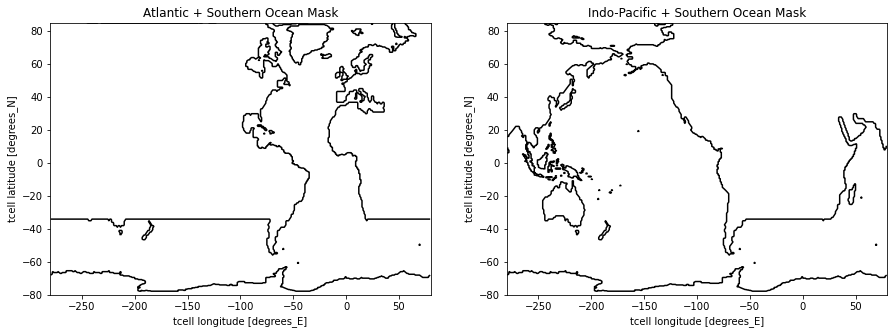

In [8]:
fig, ax=plt.subplots(1,2, figsize=(15,5))

atlantic_sector_map.plot.contour(ax=ax[0],levels=[0.5],colors='k')
ax[0].set_xlim([-280,80])
ax[0].set_ylim([-80,85])
ax[0].set_title('Atlantic + Southern Ocean Mask')
indo_sector_map.plot.contour(ax=ax[1],levels=[0.5],colors='k')
ax[1].set_xlim([-280,80])
ax[1].set_ylim([-80,85])
ax[1].set_title('Indo-Pacific + Southern Ocean Mask')



In [9]:
atlantic_sector_mask

<xarray.DataArray 'ht' (yt_ocean: 300, xt_ocean: 360)>
dask.array<where, shape=(300, 360), dtype=float64, chunksize=(300, 360), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.5 -278.5 -277.5 -276.5 ... 77.5 78.5 79.5
  * yt_ocean  (yt_ocean) float64 -77.88 -77.63 -77.38 ... 88.87 89.32 89.77
    geolon_t  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(300, 360), meta=np.ndarray>
    geolat_t  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(300, 360), meta=np.ndarray>

In [10]:
keys = ['Control','Warming','Warming x2','Cooling','Cooling x2', 'Warming w/o humidity', 'Cooling w/o humidity2']

colors = {'Control': 'k','Warming': 'r','Warming x2': 'r','Cooling':'b','Cooling x2':'b', 'Warming w/o humidity':'m','Cooling w/o humidity2':'c'}
linestyles = {'Control': '-','Warming': '-','Warming x2': '--','Cooling':'-','Cooling x2':'--', 'Warming w/o humidity':'dotted','Cooling w/o humidity2':'dotted'}


In [11]:
temp_yflux_adv = cc.querying.getvar(expt, 'temp_yflux_adv_int_z', session)
#atlantic_sector_mask*temp_yflux_adv

In [ ]:
#(atlantic_sector_mask*temp_yflux_adv).isel(time =0).isel(xt_ocean=0).isel(yu_ocean=0).plot()

In [12]:
psi = cc.querying.getvar(expt,'temp_yflux_adv_int_z',session, n=1) ## needs to be the same coordinates as what you want to mask
#atlantic_sector_mask.coords['xt_ocean'] = psi.xt_ocean.values
atlantic_sector_mask.coords['yt_ocean'] = psi.yu_ocean.values
atlantic_sector_mask = atlantic_sector_mask.rename({'xt_ocean':'xt_ocean','yt_ocean':'yu_ocean'})
#indo_sector_mask.coords['xt_ocean'] = psi.xt_ocean.values
indo_sector_mask.coords['yt_ocean'] = psi.yu_ocean.values
indo_sector_mask = indo_sector_mask.rename({'xt_ocean':'xt_ocean','yt_ocean':'yu_ocean'})



In [13]:
def find_MHF_intz_basin(ekey, basin_mask):
    expt = exptdict[ekey]['expt']
    #n_files = exptdict[ekey]['n_files']
    # n_files = 1
    #time_units = exptdict[ekey]['time_units']
    #offset = exptdict[ekey]['offset']

    temp_yflux_adv = cc.querying.getvar(expt, 'temp_yflux_adv_int_z', session)
    temp_yflux_adv = temp_yflux_adv*basin_mask
    #temp_yflux_submeso = cc.querying.getvar(expt, 'temp_yflux_submeso_int_z', session)
    MHF = (temp_yflux_adv.sel(time=slice(tstart,tend)).mean('time').sum('xt_ocean')).load()#+temp_yflux_submeso.sel(time=slice(tstart,tend)).mean('time').sum('xt_ocean')).load()
    if (ekey != '01deg'):
        temp_yflux_gm = cc.querying.getvar(expt,'temp_yflux_gm_int_z', session)
        temp_yflux_ndiffuse = cc.querying.getvar(expt, 'temp_yflux_ndiffuse_int_z',session)
        MHF = MHF + (temp_yflux_gm.sel(time=slice(tstart,tend)).mean('time').sum('xt_ocean')+temp_yflux_ndiffuse.sel(time=slice(tstart,tend)).mean('time').sum('xt_ocean')).load()
        
    latv = cc.querying.getvar(expt, 'yu_ocean',session, n=1).load()
    return latv, MHF

In [14]:
tstart = '2940-01-01'
tend = '2950-01-01'

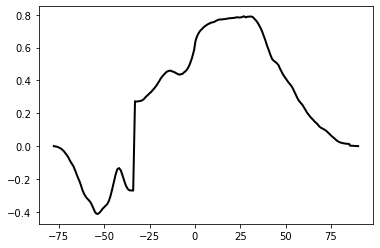

In [15]:
ekey = 'Control'
latv, MHF = find_MHF_intz_basin(ekey, atlantic_sector_mask)
hand = plt.plot(latv,MHF/1.e15,linewidth=2, label=ekey, color = colors[ekey], linestyle = linestyles[ekey])

Control
Warming
Warming x2
Cooling
Cooling x2
Warming w/o humidity
Cooling w/o humidity


Text(0.5, 1.0, 'Meridional heat flux due to advection years 1-10 - Atlantic')

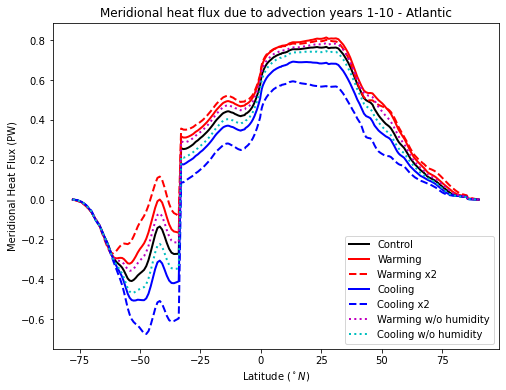

In [16]:
fig = plt.figure(figsize=(8,6))
plt.xlabel('Latitude $(^\circ N)$')
plt.ylabel('Meridional Heat Flux (PW)')
tstart = '2900-01-01'
tend = '2910-01-01'
keys = ['Control','Warming','Warming x2','Cooling','Cooling x2', 'Warming w/o humidity', 'Cooling w/o humidity']

colors = {'Control': 'k','Warming': 'r','Warming x2': 'r','Cooling':'b','Cooling x2':'b', 'Warming w/o humidity':'m','Cooling w/o humidity':'c'}
linestyles = {'Control': '-','Warming': '-','Warming x2': '--','Cooling':'-','Cooling x2':'--', 'Warming w/o humidity':'dotted','Cooling w/o humidity':'dotted'}

for ekey in keys:
    print(ekey)

    latv, MHF = find_MHF_intz_basin(ekey, atlantic_sector_mask)
    hand = plt.plot(latv,MHF/1.e15,linewidth=2, label=ekey, color = colors[ekey], linestyle = linestyles[ekey])
    
plt.legend()
plt.title('Meridional heat flux due to advection years 1-10 - Atlantic')

Control
Warming
Warming x2
Cooling
Cooling x2
Warming w/o humidity
Cooling w/o humidity
Control
Warming
Warming x2
Cooling
Cooling x2
Warming w/o humidity
Cooling w/o humidity
Control
Warming
Warming x2
Cooling
Cooling x2
Warming w/o humidity
Cooling w/o humidity
Control
Warming
Warming x2
Cooling
Cooling x2
Warming w/o humidity
Cooling w/o humidity2
Control
Warming
Warming x2
Cooling
Cooling x2
Warming w/o humidity
Cooling w/o humidity2
Control
Warming
Warming x2
Cooling
Cooling x2
Warming w/o humidity
Cooling w/o humidity2


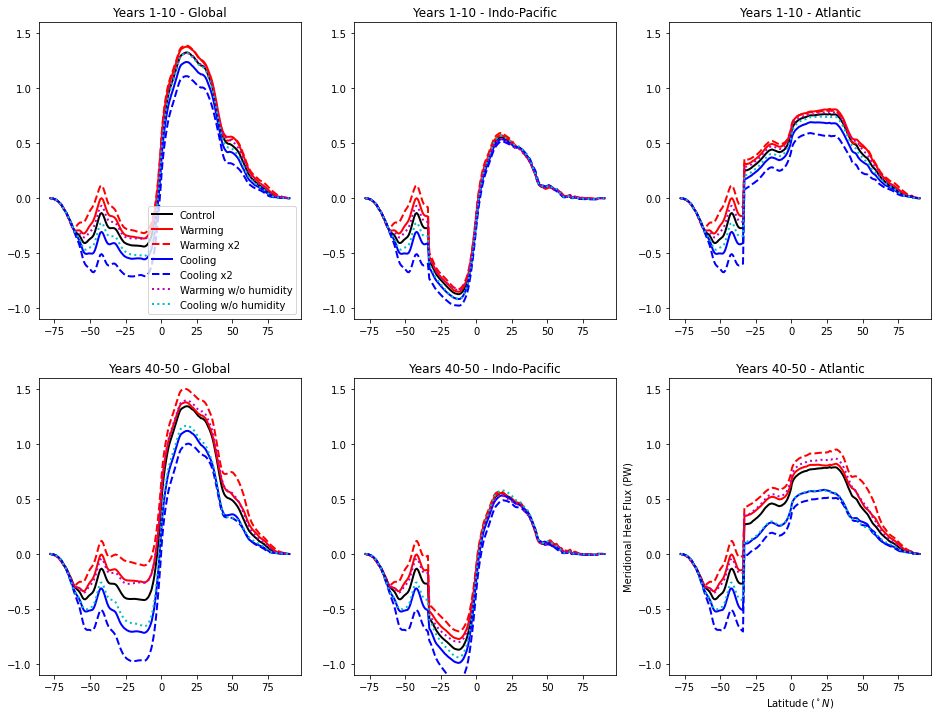

In [17]:
#fig = plt.figure(figsize=(8,6),
fig, axes = plt.subplots(ncols=3, nrows=2, figsize = (16,12))
plt.xlabel('Latitude $(^\circ N)$')
plt.ylabel('Meridional Heat Flux (PW)')

keys = ['Control','Warming','Warming x2','Cooling','Cooling x2', 'Warming w/o humidity', 'Cooling w/o humidity']
colors = {'Control': 'k','Warming': 'r','Warming x2': 'r','Cooling':'b','Cooling x2':'b', 'Warming w/o humidity':'m','Cooling w/o humidity':'c'}
linestyles = {'Control': '-','Warming': '-','Warming x2': '--','Cooling':'-','Cooling x2':'--', 'Warming w/o humidity':'dotted','Cooling w/o humidity':'dotted'}
tstart = '2900-01-01'
tend = '2910-01-01'

for ekey in keys:
    print(ekey)

    latv, MHF = find_MHF_intz(ekey)
    hand = axes[0,0].plot(latv,MHF/1.e15,linewidth=2, label=ekey, color = colors[ekey], linestyle = linestyles[ekey])
    
axes[0,0].legend()
axes[0,0].set_title('Years 1-10 - Global')
axes[0,0].set_ylim(-1.1,1.6)
for ekey in keys:
    print(ekey)

    latv, MHF = find_MHF_intz_basin(ekey, indo_sector_mask)
    hand = axes[0,1].plot(latv,MHF/1.e15,linewidth=2, label=ekey, color = colors[ekey], linestyle = linestyles[ekey])
axes[0,1].set_title('Years 1-10 - Indo-Pacific')
axes[0,1].set_ylim(-1.1,1.6)
for ekey in keys:
    print(ekey)

    latv, MHF = find_MHF_intz_basin(ekey, atlantic_sector_mask)
    hand = axes[0,2].plot(latv,MHF/1.e15,linewidth=2, label=ekey, color = colors[ekey], linestyle = linestyles[ekey])
axes[0,2].set_title('Years 1-10 - Atlantic')
axes[0,2].set_ylim(-1.1,1.6)
keys = ['Control','Warming','Warming x2','Cooling','Cooling x2', 'Warming w/o humidity', 'Cooling w/o humidity2']
colors = {'Control': 'k','Warming': 'r','Warming x2': 'r','Cooling':'b','Cooling x2':'b', 'Warming w/o humidity':'m','Cooling w/o humidity2':'c'}
linestyles = {'Control': '-','Warming': '-','Warming x2': '--','Cooling':'-','Cooling x2':'--', 'Warming w/o humidity':'dotted','Cooling w/o humidity2':'dotted'}
tstart = '2940-01-01'
tend = '2950-01-01'

for ekey in keys:
    print(ekey)

    latv, MHF = find_MHF_intz(ekey)
    hand = axes[1,0].plot(latv,MHF/1.e15,linewidth=2, label=ekey, color = colors[ekey], linestyle = linestyles[ekey])
    
axes[1,0].set_title('Years 40-50 - Global')
axes[1,0].set_ylim(-1.1,1.6)
for ekey in keys:
    print(ekey)

    latv, MHF = find_MHF_intz_basin(ekey, indo_sector_mask)
    hand = axes[1,1].plot(latv,MHF/1.e15,linewidth=2, label=ekey, color = colors[ekey], linestyle = linestyles[ekey])
axes[1,1].set_title('Years 40-50 - Indo-Pacific')
axes[1,1].set_ylim(-1.1,1.6)
for ekey in keys:
    print(ekey)

    latv, MHF = find_MHF_intz_basin(ekey, atlantic_sector_mask)
    hand = axes[1,2].plot(latv,MHF/1.e15,linewidth=2, label=ekey, color = colors[ekey], linestyle = linestyles[ekey])
axes[1,2].set_title('Years 40-50 - Atlantic')
axes[1,2].set_ylim(-1.1,1.6)
plt.savefig('figures/meridional_heat_flux_basin')